Inspired from PyTorch Tutorial [Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [24]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import os
import random
import pickle as pkl

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchnlp.datasets import imdb_dataset
from torchnlp.datasets import penn_treebank_dataset
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0
EOS_token = 1
MASKED_token = 2
MAX_LENGTH = 42

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOSTOKEN": 0, "EOSTOKEN": 1, "MASKEDTOKEN": 2}
        self.index2word = {0: "SOSTOKEN", 1: "EOSTOKEN", 2: "MASKEDTOKEN"}
        self.word2count = {"SOSTOKEN": 0, "EOSTOKEN": 0, "MASKEDTOKEN": 0}
        
        self.n_words = 3  # Count SOS and EOS and Masked token

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def unicodeToAscii(s):
    """
    Turn a Unicode string to plain ASCII, thanks to
    https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):  # Lowercase, trim, and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s = " ".join(s.split()[:40])
    return s

In [4]:
def readLang(dataset_title):
    """
    Args:
        dataset_title: either 'imdb' or 'ptb'
    """
    print("Reading lines...")
    if dataset_title == 'imdb':
        train = imdb_dataset(train=True, directory='../data/')
        # Read the dataset and split into lines
        lines = [train[ind]['text'].strip() for ind, doc in enumerate(train)]
        # Normalize lines
        lines = [' '.join(["SOSTOKEN", normalizeString(s), "EOSTOKEN"]) for s in lines]
        lang = Lang(dataset_title)
    elif dataset_title == 'ptb':
        raise NotImplementedError
    return lang, lines

In [5]:
def prepareData(dataset_title):
    lang, lines = readLang(dataset_title)
    print("Read %s sentence pairs" % len(lines))
    print("Counting words...")
    for l in lines:
        lang.addSentence(l)
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, lines

The Encoder
-----------

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        #self.gru = nn.GRU(hidden_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        #output, hidden = self.gru(output, hidden)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

The Decoder
-----------

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        #self.gru = nn.GRU(hidden_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        #output, hidden = self.gru(output, hidden)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #print(input, embedded.shape, hidden[0].shape, encoder_outputs.shape)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        #print(embedded.shape, attn_applied.shape)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
def generate_mask(sequence_length, batch_size=None, is_present=0.7):
    """
    e.g.
    returns: [1, 1, 0, 1, 0, 1]
    """
    if batch_size is not None:
        mask = np.random.binomial(1, is_present, size=(batch_size, sequence_length))
    elif batch_size is None:
        mask = np.random.binomial(1, is_present, size=(sequence_length,))
    return torch.from_numpy(mask).long()

In [10]:
def transform_input_with_is_missing_token(inputs, targets_present, masked_value="MASKEDTOKEN"):
    """
    e.g. 
        inputs = [a, b, c, d, e]
        targets = [b, c, d, e, f]
        targets_present = [1, 0, 1, 0, 1]
        masked_value = <m>
        
    then,
        transformed_input = [a, b, <m>, d, <m>]
        
    Args:
        inputs: tensor with shape [sequence_length] with tokens
        targets_present: tensor with shape [sequence_length] with 1. representing presence of a word of dtype=torch.long
        
    from github.com/tensorflow/models/blob/master/research/maskgan
    """
    transformed_input = [inputs[0]]
    for ind, word in enumerate(inputs[1:]):
        if targets_present[ind] == 1:
            transformed_input.append(word)
        elif targets_present[ind] == 0:
            transformed_input.append(masked_value)
    transformed_input[-1] = inputs[-1]
    return transformed_input

In [11]:
print(transform_input_with_is_missing_token(list(string.ascii_lowercase),
                                      [(ind % 5) % 2 for ind, letter in enumerate(string.ascii_lowercase)]))

['a', 'MASKEDTOKEN', 'c', 'MASKEDTOKEN', 'e', 'MASKEDTOKEN', 'MASKEDTOKEN', 'h', 'MASKEDTOKEN', 'j', 'MASKEDTOKEN', 'MASKEDTOKEN', 'm', 'MASKEDTOKEN', 'o', 'MASKEDTOKEN', 'MASKEDTOKEN', 'r', 'MASKEDTOKEN', 't', 'MASKEDTOKEN', 'MASKEDTOKEN', 'w', 'MASKEDTOKEN', 'y', 'z']


Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsForTrain(lang, sentence):
    mask = generate_mask(len(sentence))
    target_tensor = tensorFromSentence(lang, sentence)
    transformed_sentence = " ".join(transform_input_with_is_missing_token(sentence.split(), mask))
    input_tensor = tensorFromSentence(lang, transformed_sentence)
    return input_tensor, target_tensor

def indexFromTensor(lang, decoder_output):
    return decoder_output.max(0)[1]

Training the Model
------------------

In [13]:
MAX_LENGTH = 42 # max(map(lambda x: len(x.split()), imdb_lines)) == 2516

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, lang, criterion, max_length=MAX_LENGTH):
    #c_ = time()
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

        
    decoder_input = input_tensor[0]
    decoder_hidden = encoder_hidden

    for di in range(input_length):        
        #print(encoder_outputs.shape)
        decoder_output, decoder_hidden, decoder_attention  = decoder(
            decoder_input, decoder_hidden, encoder_outputs)      
        loss += criterion(decoder_output, target_tensor[di + 1])

        if input_tensor[di + 1].item() == MASKED_token:
            #topv, topi = decoder_output.topk(1)
            #decoder_input = topi.squeeze().detach()  # detach from history as input
            #print(decoder_output.min())
            token_sample = torch.multinomial(torch.exp(decoder_output), 1)
            decoder_input = token_sample.squeeze().detach()
        else:
            decoder_input = input_tensor[di + 1]

        if input_tensor[di + 1].item() == EOS_token:
            break

    
    loss.backward()

    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / input_length

In [14]:
from time import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder, decoder, lang, lines, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    #start = time.time()
    start = time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsForTrain(lang, random.choice(lines)) for i in range(n_iters)]
    training_pairs = [tensorsForTrain(lang, random.choice(lines)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss() # replaced NLLLoss()
    
    for iter in range(1, n_iters + 1):
        #c_ = time()
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        #print('Pairs created ...', time() - c_)
        #c_ = time()
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, lang, criterion)
        #print('Loss is done...', time() - c_)
        #c_ = time()
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)
        

Plotting results
----------------

In [16]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    #print(points)
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.grid()
    plt.show();
    print('plot was shown')

Evaluation
==========

In [17]:
"""def evaluate(encoder, decoder, input_lang, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        #decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_input = input_tensor[0]
        decoder_hidden = encoder_hidden

        decoded_words = ['SOSTOKEN']
        #decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):        
            
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)      

            if input_tensor[di + 1].item() == MASKED_token:
                #topv, topi = decoder_output.topk(1)
                #decoder_input = topi.squeeze().detach()  # detach from history as input
                #print(decoder_output.min())
                token_sample = torch.multinomial(torch.exp(decoder_output), 1)
                decoder_input = token_sample.squeeze().detach()
                decoded_words.append(input_lang.index2word[decoder_input.item()].upper())
            else:
                decoder_input = input_tensor[di + 1]
                decoded_words.append(input_lang.index2word[decoder_input.item()])
            
            
            if input_tensor[di + 1].item() == EOS_token:
                decoded_words.append('EOSTOKEN')
                break
                
        return decoded_words
    #, decoder_attentions[:di + 1]""";

In [18]:
"""def evaluateRandomly(encoder, decoder, input_lang, n=10):
    for i in range(n):
        
        sentence = random.choice(imdb_lines)
        pair = tensorsForTrain(input_lang, sentence)
        #print('masked:\n', *list(map(lambda x: input_lang.index2word[x.item()], pair[0])))
        print('real:\n', sentence)
        #print('filled:', *list(map(lambda x: input_lang.index2word[x.item()], 
        #                           evaluate(encoder, decoder, input_lang, sentence))))
        #mask = generate_mask(len(sentence.split()), is_present=0.8)
        print('filled:\n', *evaluate(encoder, decoder, input_lang, 
                                     pair[1]))""";

In [25]:
%%time
dataset = 'imdb'
lang_filename = './data/' + dataset + '_lang.pkl'
if os.path.exists(lang_filename):
    with open(lang_filename, 'rb') as file:
        (lang, lines) = pkl.load(file)
else:
    lang, lines = prepareData(dataset)
    with open(lang_filename, 'wb') as file:
        pkl.dump((lang, lines), file)

Wall time: 59 ms


In [29]:
hidden_size = 64
encoder1 = EncoderRNN(lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)
#decoder1 = DecoderRNN(hidden_size, imdb_lang.n_words)

In [34]:
dir(encoder1.lstm)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_buffers',
 '_all_weights',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_data_ptrs',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_modules',
 '_parameters',
 '_slow_forward',
 '_tracing_name',
 '_version',
 'add_module',
 'all_weights',
 'apply',
 'batch_first',
 'bias',
 'bias_hh_l0',
 'bias_ih_l0',
 'bidirectional',
 'check_forward_args',
 'children',
 'cpu',
 'cuda',
 'double',
 'dropout',
 'dropout_state',
 'dump_patches',
 'eval',
 'extra_repr',
 'flatten_parameters',
 'float',
 'forward',
 'half',
 'hidden_size',

0m 2s (- 0m 25s) (2 10%) 10.1351
0m 5s (- 0m 22s) (4 20%) 10.1363
0m 8s (- 0m 19s) (6 30%) 10.1121
0m 10s (- 0m 15s) (8 40%) 10.0048
0m 12s (- 0m 12s) (10 50%) 10.1019
0m 15s (- 0m 10s) (12 60%) 10.0990
0m 17s (- 0m 7s) (14 70%) 10.1015
0m 20s (- 0m 5s) (16 80%) 10.0723
0m 22s (- 0m 2s) (18 90%) 10.0054
0m 24s (- 0m 0s) (20 100%) 9.9687


<Figure size 432x288 with 0 Axes>

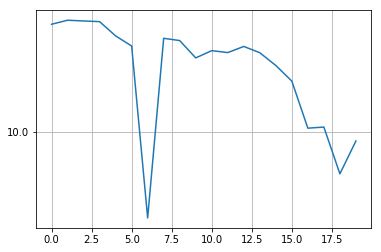

plot was shown
Wall time: 25.2 s


In [32]:
%%time
trainIters(encoder1, attn_decoder1, lang, lines, 20, print_every=2, plot_every=1)

In [31]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

print("Total number of trainable parameters:", count_parameters(encoder1) + count_parameters(attn_decoder1))

Total number of trainable parameters: 6398282


In [33]:
evaluateRandomly(encoder1, decoder1, imdb_lang, 5)

real:
 SOSTOKEN nothin there ain t nothing in room but you ain t got no business going in there anyway so stay out you understand stay out br br never has there been such a feat of psychological horror as this film EOSTOKEN
filled:
 SOSTOKEN nothin there ain t nothing in room but you ain t got no business going in there anyway so stay out you understand stay out br br never has there been such a feat of psychological horror as this film EOSTOKEN EOSTOKEN
real:
 SOSTOKEN deaf secretary carla emmanuelle devos is bullied by her mean spirited male colleagues br br when they suggest she needs an assistant it seems like the final insult but when the first applicant is ex con paul vincent cassel she EOSTOKEN
filled:
 SOSTOKEN deaf secretary carla emmanuelle devos is bullied by her mean spirited male colleagues br br when they suggest she needs an assistant it seems like the final insult but when the first applicant is ex con paul vincent cassel she EOSTOKEN EOSTOKEN
real:
 SOSTOKEN i really f